## PU Learning For News
Initial work

Mainly to start exploring how to vectorize texts and also identify true negatives

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# nltk.download('punkt')
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/izimmer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/izimmer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/izimmer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
input_file = "./article_dataset.csv"
df_raw = pd.read_csv(input_file, index_col="id")
df_raw = preprocessing.clean_df(df_raw)
df_raw = df_raw[df_raw['cleaned_text'].str.strip() != ""].copy()
df_raw.reset_index(inplace=True)
df_raw['id'] = df_raw.index
df_raw["clean_title"] = df_raw['title'].apply(preprocessing.clean_text)

df = df_raw.copy()
df = preprocessing.turn_into_pu(df, 0.5)

X_train, X_test, y_train, y_test = preprocessing.test_train_split(df)
y_train.index = X_train.index
y_test_true = df_raw.loc[y_test.index, 'label']

X_train['tokens'] = X_train['cleaned_text'].apply(lambda x: x.split())
df.head()

,id,title,author,text,label,cleaned_text,clean_title
0,0,House Dem Aide: We Didn't Even See Comey's Let...,Darrell Lucus,House Dem Aide: We Didn't Even See Comey's Let...,1,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circle roundabout rather...,flynn hillary clinton big woman campus breitbart
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october tension intellig...,truth might get fired
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,video civilian killed single u airstrike ident...,civilian killed single u airstrike identified
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six year prison ...,iranian woman jailed fictional unpublished sto...


## Vectorizing Text
TF-IDF words

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=True)
tfidf_matrix = vectorizer.fit_transform(X_train['cleaned_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_train.index)

pca = PCA(n_components=6)
principal_components = pca.fit_transform(tfidf_df)
print("Explained Variance: ", pca.explained_variance_ratio_.cumsum())

/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Visualizing Word Vectorization with PCA 

In [ ]:
pca_plot = PCA(n_components=2)
principal_components_plot = pca_plot.fit_transform(tfidf_df)

print("Explained Variance: ", pca_plot.explained_variance_ratio_.cumsum())


temp = pd.DataFrame(principal_components_plot, columns=['x', 'y'])
temp['label'] = y_train

# Plot with Plotly Express
fig = px.scatter(temp, x='x', y='y', color='label', title='Scatter Plot with Correlated Colors')
fig.show()

Explained Variance:  [0.01389154 0.02245539]


### Vectorizing through Document Content

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def sentiment_maker(df: pd.DataFrame, type:str):
    df['sentiment'] = df[type].apply(analyzer.polarity_scores)
    df = pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)
    df.rename(columns={col: f"{col}_{type}" for col in ["pos", "neu", "neg"]}, inplace=True)
    return df

def count_stop_words(tokens):
    stop_word_count = sum(1 for word in tokens if word in stop_words)
    return stop_word_count / len(tokens)

X_vec = X_train.copy()
X_vec['len'] = X_vec['tokens'].apply(lambda x: len(x))

X_vec = sentiment_maker(X_vec, "cleaned_text")
X_vec = sentiment_maker(X_vec, "clean_title")

X_vec['percent_stop'] = X_vec['tokens'].apply(count_stop_words)
X_vec

,id,title,author,text,cleaned_text,clean_title,tokens,len,neg_cleaned_text,neu_cleaned_text,pos_cleaned_text,compound,neg_clean_title,neu_clean_title,pos_clean_title,compound,percent_stop
13931,13931,Illegal Migrant Abandoned in Desert Calls 911 ...,Bob Price,A severely dehydrated illegal alien called 911...,severely dehydrated illegal alien called plead...,illegal migrant abandoned desert call help,"[severely, dehydrated, illegal, alien, called,...",387,0.261,0.665,0.074,-0.9981,0.537,0.244,0.220,-0.5994,0.000000
8691,8691,Experimental GM crops from Dow Chemical and Du...,"Ethan A. Huff, staff writer",Experimental GM crops from Dow Chemical and Du...,experimental gm crop dow chemical dupont fail ...,experimental gm crop dow chemical dupont fail ...,"[experimental, gm, crop, dow, chemical, dupont...",368,0.123,0.773,0.103,-0.9261,0.304,0.696,0.000,-0.5423,0.000000
19923,19923,Juror explanation for Ammon Bundy verdict,Alex Ansary,Juror explanation for Ammon Bundy verdict 11/0...,juror explanation ammon bundy verdict oregonli...,juror explanation ammon bundy verdict,"[juror, explanation, ammon, bundy, verdict, or...",1267,0.165,0.695,0.140,-0.9946,0.000,0.714,0.286,0.1531,0.001579
18438,18438,What To Do In An Ammo Panic,Luke Stranahan,Firearms panics happen over a variety of thing...,firearm panic happen variety thing like act do...,ammo panic,"[firearm, panic, happen, variety, thing, like,...",790,0.195,0.659,0.145,-0.9954,0.767,0.233,0.000,-0.5106,0.005063
11730,11730,Prep Blog Review: How To Survive The Flu & Col...,Drew Stratton,"Drew Stratton October 29, 2016 Prep Blog Revie...",drew stratton october prep blog review survive...,prep blog review survive flu cold season,"[drew, stratton, october, prep, blog, review, ...",396,0.145,0.643,0.212,0.9826,0.302,0.698,0.000,-0.3818,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18160,18160,Forget Too Much TV. It's Too Big TV We Should ...,James Poniewozik,It may have been “Tiny House Nation” that fina...,may tiny house nation finally broke last month...,forget much tv big tv worry new york time,"[may, tiny, house, nation, finally, broke, las...",500,0.050,0.714,0.237,0.9986,0.407,0.593,0.000,-0.5859,0.008000
7571,7571,Rams Select Jared Goff With No. 1 Pick in N.F....,Ken Belson,CHICAGO — The Los Angeles Rams chose quarte...,chicago los angeles ram chose quarterback jare...,ram select jared goff pick nfl draft new york ...,"[chicago, los, angeles, ram, chose, quarterbac...",619,0.066,0.786,0.149,0.9921,0.000,1.000,0.000,0.0000,0.000000
8430,8430,Jon Stewart Finally Comments On Donald Trump's...,Amanda Froelich,Jon Stewart may no longer be the host of The D...,jon stewart may longer host daily show still p...,jon stewart finally comment donald trump lewd ...,"[jon, stewart, may, longer, host, daily, show,...",20,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000,0.000000
11790,11790,A Positive Outlook May Be Good for Your Health...,Jane E. Brody,“Look on the sunny side of life. ” “Turn your ...,look sunny side life turn face toward sun shad...,positive outlook may good health new york time,"[look, sunny, side, life, turn, face, toward, ...",630,0.126,0.571,0.303,0.9993,0.000,0.480,0.520,0.7579,0.000000


In [ ]:
X_vec_numeric = X_vec.select_dtypes(include=np.number).drop(columns=["id"])
principal_components_df = pd.DataFrame(principal_components)
temp_index = X_vec.index
X_vec_numeric.reset_index(inplace=True)
principal_components_df.reset_index(inplace=True)
x_train_combined = pd.concat([X_vec_numeric, principal_components_df], axis=1)
x_train_combined.drop(columns=['index'], inplace=True)
x_train_combined.set_index(temp_index, inplace=True)
x_train_combined.columns = x_train_combined.columns.astype(str)
x_train_combined

,len,neg_cleaned_text,neu_cleaned_text,pos_cleaned_text,compound,neg_clean_title,neu_clean_title,pos_clean_title,compound,percent_stop,0,1,2,3,4,5
13931,387,0.261,0.665,0.074,-0.9981,0.537,0.244,0.220,-0.5994,0.000000,-0.084571,-0.035173,-0.001609,-0.026317,-0.012867,-0.077256
8691,368,0.123,0.773,0.103,-0.9261,0.304,0.696,0.000,-0.5423,0.000000,-0.091849,-0.015140,0.019476,0.009487,-0.005745,0.011015
19923,1267,0.165,0.695,0.140,-0.9946,0.000,0.714,0.286,0.1531,0.001579,-0.043841,0.002023,0.014232,-0.020436,-0.055111,-0.021324
18438,790,0.195,0.659,0.145,-0.9954,0.767,0.233,0.000,-0.5106,0.005063,-0.073256,-0.010919,-0.005511,0.037100,-0.057328,0.026187
11730,396,0.145,0.643,0.212,0.9826,0.302,0.698,0.000,-0.3818,0.000000,-0.086789,-0.019843,0.006223,0.026949,-0.061052,0.037701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18160,500,0.050,0.714,0.237,0.9986,0.407,0.593,0.000,-0.5859,0.008000,-0.067964,-0.030028,0.021925,0.040454,-0.061049,0.027081
7571,619,0.066,0.786,0.149,0.9921,0.000,1.000,0.000,0.0000,0.000000,-0.063839,-0.039830,0.030263,0.017077,-0.028337,0.003484
8430,20,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000,0.000000,-0.020673,-0.004384,0.004137,0.099276,0.065628,-0.072419
11790,630,0.126,0.571,0.303,0.9993,0.000,0.480,0.520,0.7579,0.000000,-0.072728,-0.039310,0.004704,0.025864,-0.119535,0.068809


## Finding True Negatives
**Not Used Currently**\
Trying to find true negatives through knn, does not seem to work:\
https://link.springer.com/article/10.1007/s10994-020-05877-5#Sec22

In [17]:
k = 5
knn = NearestNeighbors(n_neighbors=k)

knn.fit(temp)

distances, indices = knn.kneighbors(temp)

no_positive_neighbors = []

for idx in range(len(y_train)):
    neighbors_labels = y_train.iloc[indices[idx]]

    if all(neighbors_labels == 0):
        no_positive_neighbors.append(idx)

print("Data points with no positive neighbors:", len(no_positive_neighbors))
print("True comparision:", df_raw.loc[no_positive_neighbors, 'label'].value_counts())

Data points with no positive neighbors: 40
True comparision: label
1    21
0    19
Name: count, dtype: int64


### Trying Logistic

In [ ]:
### Preprocessing X test
## Same preprocessing X train went through
## Utilizing fitted pca and tfidf
test_tfidf_matrix = vectorizer.transform(X_test['cleaned_text'])

test_tfidf = pd.DataFrame(test_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_test.index)
test_pca = pd.DataFrame(pca.transform(test_tfidf))


X_test_vec = X_test.copy()
X_test_vec['tokens'] = X_test_vec['cleaned_text'].apply(lambda x: x.split())
X_test_vec['len'] = X_test_vec['tokens'].apply(lambda x: len(x))
X_test_vec = sentiment_maker(X_test_vec, "cleaned_text")
X_test_vec = sentiment_maker(X_test_vec, "clean_title")
X_test_vec['percent_stop'] = X_test_vec['tokens'].apply(count_stop_words)

X_vec_numeric = X_test_vec.select_dtypes(include=np.number).drop(columns=["id"])
x_test_index = X_test.index
X_vec_numeric.reset_index(inplace=True)
test_pca.reset_index(inplace=True)
x_test_processed = pd.concat([X_vec_numeric, test_pca], axis=1)
x_test_processed.set_index(x_test_index, inplace=True)
x_test_processed.columns = x_test_processed.columns.astype(str)
x_test_processed.drop(columns=['index'], inplace=True)

### Creating Logistic Regression Model
Model trained on PU data\
Confusion Matrix based on true values of y

/Users/izimmer/School/CS5806/env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



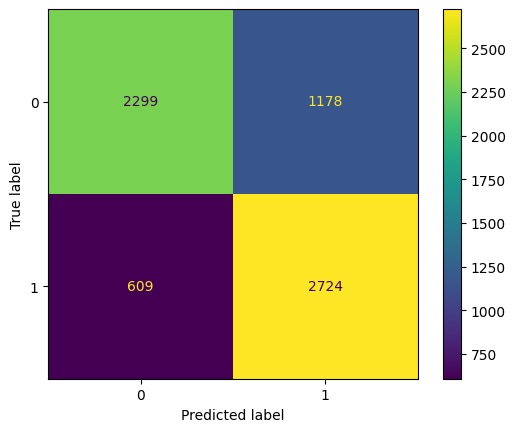

In [55]:
## Making Model
logreg = LogisticRegression(random_state=97)
logreg.fit(temp, y_train)

y_pred_proba = logreg.predict_proba(x_test_processed)
y_pred = [1 if proba[1] > 0.75 else 0 for proba in y_pred_proba]
confusion_matrix = metrics.confusion_matrix(y_test_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [54]:
percentages = np.arange(0, 1, 0.05)
accuracy = []
for cutoff in percentages:
    y_pred = [1 if proba[1] > cutoff else 0 for proba in y_pred_proba]
    accurate = sum(y_pred == y_test_true) / len(y_test_true)
    accuracy.append(accurate)
    
data = {
    'Cutoff': percentages,
    'Accuracy': accuracy
}

accutacy_table = pd.DataFrame(data)

# Create a line plot
fig = px.line(accutacy_table, x='Cutoff', y='Accuracy', title='Accuracy vs Cutoff',
              labels={'Cutoff': 'Threshold Cutoff', 'Accuracy': 'Accuracy'})
fig.show()

Cuttoff with best accuracy matches ratio of negative to postiive data ratio on the original dataset